In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
from batch_sv_system_utils import get_embeds, cosine_sim, compute_error, compute_eer
from batch_sv_system_utils import run_trial, plot_score 

In [278]:
# for kaldi_io
os.environ['KALDI_ROOT'] = "/dataset/muncok/kaldi/"

In [280]:
from utils import key2df, df2dict
keys = pickle.load(open("xvector_embeds/sv_keys.pkl", "rb"))
key_df = key2df(keys)
id2idx, idx2id = df2dict(key_df) 

In [315]:
# thresholds
vT = 10
eT = 20

In [302]:
import kaldi_io
import itertools
import subprocess

def compute_plda_score(enr_embeds, test_embeds, plda_dir, score_dir="./plda_score"):
    enr_keys = ['enr{}'.format(i) for i in range(len(enr_embeds))]
    test_keys = ['test_{}'.format(i) for i in range(len(test_embeds))]
    keys = enr_keys + test_keys
    embeds = np.concatenate([enr_embeds, test_embeds])

    if not os.path.isdir(score_dir):
        os.makedirs(score_dir)
    ark_scp_output='ark:| copy-vector ark:- ark,scp:{output}/feats.ark,{output}/feats.scp'.format(output=score_dir)
    with kaldi_io.open_or_fd(ark_scp_output, "wb") as f:
        for key, vec in zip(keys, embeds):
            kaldi_io.write_vec_flt(f, vec.squeeze(), key=str(key))

    with open("{}/kaldi_trial".format(score_dir), "w") as f:
        trial_pairs = itertools.product(enr_keys, test_keys)
        for pair in trial_pairs:
            f.write(" ".join(pair))
            f.write("\n")

    subprocess.call("./plda_score.sh  {} {}".format(plda_dir, score_dir), shell=True)
    
    plda_scores = pd.read_csv("{}/plda_scores".format(score_dir), delimiter=" ", names=["enroll", "test", "score"]).score
    plda_scores = np.array(plda_scores)
    plda_scores = plda_scores.reshape(len(enr_keys), -1)
    assert plda_scores.shape[1] == len(test_embeds)
    
    return plda_scores 

## PLDA Score

In [305]:
plda_model_dir = "embeddings/voxc2_fbank64_voxc2untied_tdnn7_embeds/plda_train/"

### sv_embeds 

In [289]:
# full frames
sv_embeds_full = np.load("xvector_tdnn7_embeds/sv_embeds.npy")
# 300 frames
sv_embeds_300f = np.load("embeddings/voxc2_fbank64_voxc2untied_tdnn7_300f_embeds/sv_embeds.npy")
# 100 frames
sv_embeds_100f = np.load("embeddings/voxc2_fbank64_voxc2untied_tdnn7_100f_embeds/sv_embeds.npy")

### Trials

In [287]:
trial = pickle.load(open("trials/enr306/enr306_closedset_big/FS_5//trials.pkl", "rb"))
trial_info = pickle.load(open("trials/enr306/enr306_closedset_big/FS_5/trial_info.pkl", "rb"))
# sort trials by enr_spk
trial = sorted(trial, key=lambda x: x[0])
t_idx = 13
enr_spk, enr_ids, test_trial, adapt_trial, ood_trial = trial[t_idx]

### Trial embeds 

In [290]:
enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx)
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx)

In [316]:
adapt_score_fusion = compute_plda_score(enr_embeds, adapt_embeds, plda_model_dir).mean(0)
adapt_enr_idx = np.nonzero(adapt_score_fusion > eT)
adapt_enr_ids = np.array(adapt_trial[0])[adapt_enr_idx]
total_enr_ids = np.concatenate([enr_ids, adapt_enr_ids])
total_enr_embeds = get_embeds(total_enr_ids, sv_embeds, id2idx)

In [317]:
adapt_enr_ids

array(['id10041-mcpkLfUBzeU-00002', 'id10041-9THGEtI-rv8-00014',
       'id10041-Tnd3CRhELa0-00002', 'id10041-D3dHTB6l9r0-00001',
       'id10041-mcpkLfUBzeU-00005', 'id10041-mcpkLfUBzeU-00004',
       'id10041-bkT-M07CrjA-00003', 'id10041-3-NYAniM6Fc-00001',
       'id10041-WZnAngBVsmM-00012', 'id10041-D3dHTB6l9r0-00002',
       'id10041-SlV8vLqJwKo-00006', 'id10041-SlV8vLqJwKo-00005',
       'id10041-n9rD9-kU2Mw-00001', 'id10041-9THGEtI-rv8-00008',
       'id10041-D3dHTB6l9r0-00005', 'id10041-mcpkLfUBzeU-00006',
       'id10041-PZni1fi5MTQ-00003', 'id10041-qsX7s9M3lbk-00002',
       'id10041-5g4NwozVJpA-00012', 'id10041-jar0wj_nfJk-00003',
       'id10041-LvoztHyRXy8-00004', 'id10041-airbUybc41Y-00001',
       'id10041-yWcOMdVRUsc-00001', 'id10041-mcpkLfUBzeU-00010',
       'id10041-Tnd3CRhELa0-00001', 'id10041-5g4NwozVJpA-00007',
       'id10041-HBF8LIr8RG4-00002', 'id10041-airbUybc41Y-00002'],
      dtype='<U25')

err=0.0000, eer=0.0000, fpr=0.0000, fnr=0.0000, thres=10.0000


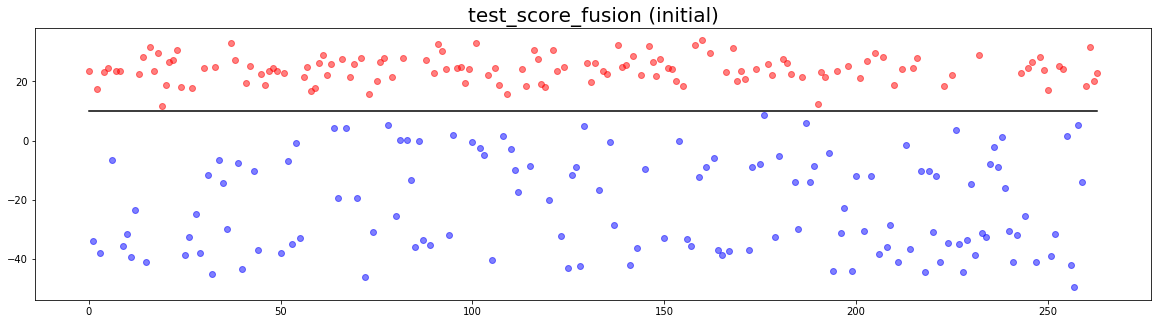

In [318]:
test_score_fusion = compute_plda_score(enr_embeds, test_embeds, plda_model_dir).mean(0)
plot_score(test_score_fusion, test_trial[1], vT, "test_score_fusion (initial)")

err=0.0038, eer=0.0000, fpr=0.0076, fnr=0.0000, thres=10.0000


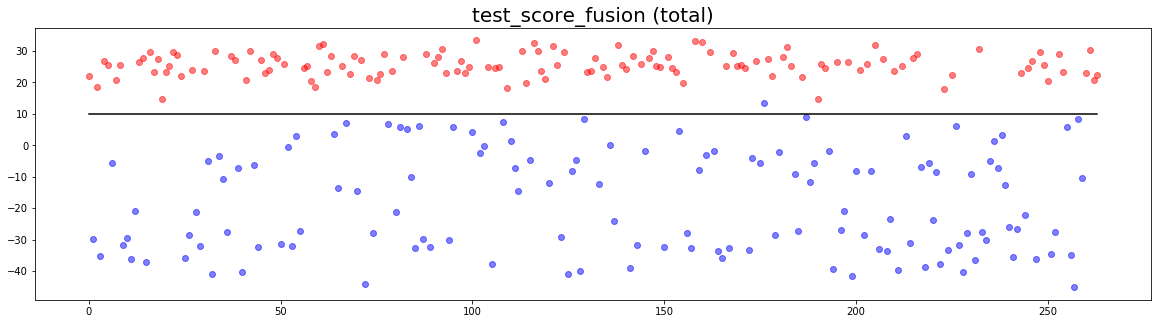

In [319]:
test_score_fusion = compute_plda_score(total_enr_embeds, test_embeds, plda_model_dir).mean(0)
plot_score(test_score_fusion, test_trial[1], vT, "test_score_fusion (total)")

### Iterate trials

## Searching the best enrollmnet

In [210]:
test_labels = np.array(test_trial[1])
plda_single_scores = plda_scores.reshape(len(enr_keys),-1)
fnr_trial_idx = np.nonzero((plda_single_scores.mean(0) < 20) & (test_labels == 1))

ValueError: operands could not be broadcast together with shapes (104,) (652,) 

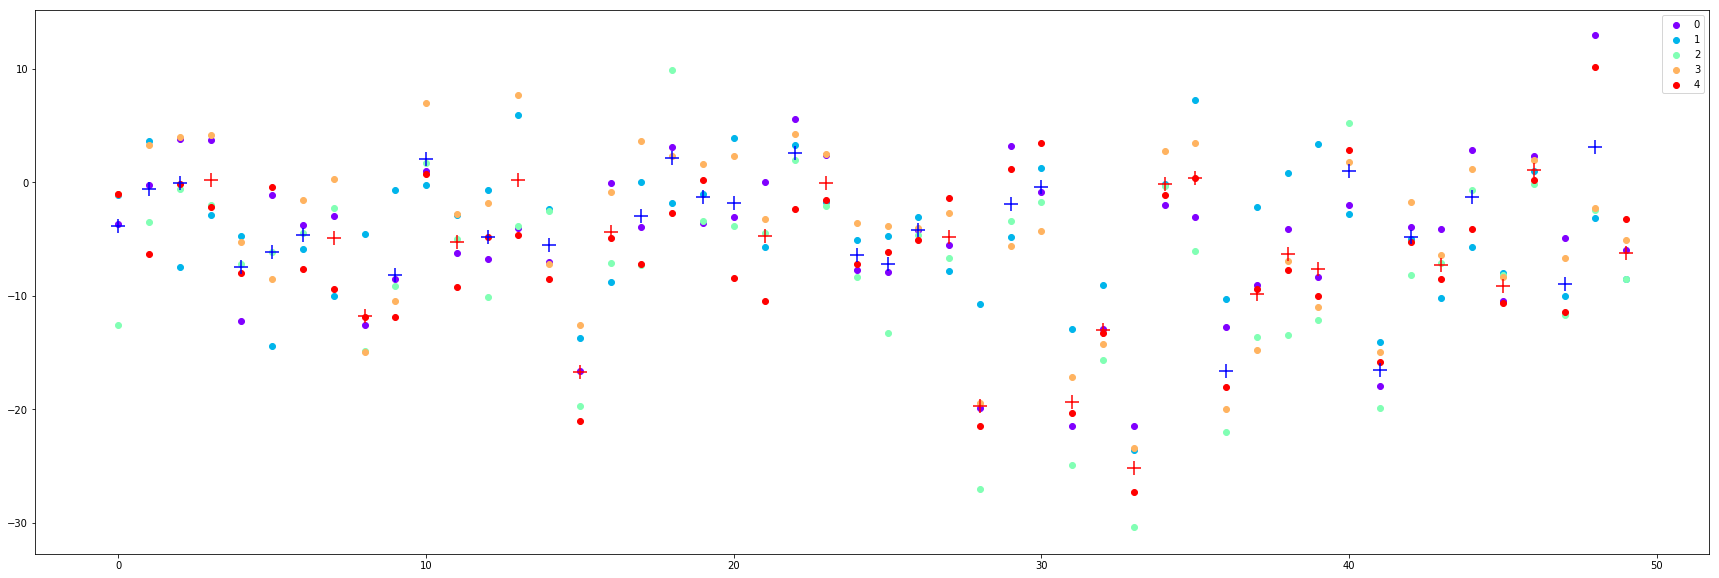

In [211]:
scores_subset = plda_single_scores[0:5, 0:50]
labels_subset = test_labels[0:50]
plt.figure(figsize=(30, 10))
x = np.arange(scores_subset.shape[1])
ys = scores_subset
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
s_set = []
for y, c in zip(ys, colors):
    s = plt.scatter(x, y, color=c)
    s_set.append(s)
plt.legend(s_set, range(len(s_set)))
y_mean = scores_subset.mean(0)
plt.scatter(x[labels_subset==1], y_mean[labels_subset==1], marker='+', s=200, color='r')
plt.scatter(x[labels_subset==0], y_mean[labels_subset==0], marker='+', s=200, color='b')

In [83]:
total_enr_ids[:5]

array(['id11181-evLtLnK_myA-00008', 'id11181-evLtLnK_myA-00010',
       'id11181-0MkUMDGw5vo-00012', 'id11181-ZT8VRzK65iY-00003',
       'id11181-vT9LdyTsG2M-00007'], dtype='<U25')

err=0.2512, eer=0.0049, fpr=0.0000, fnr=0.5024, thres=20.0000


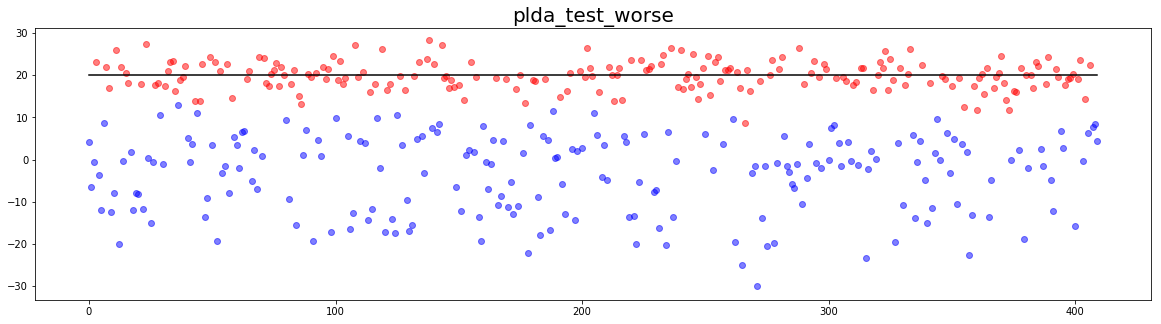

err=0.1927, eer=0.0098, fpr=0.0000, fnr=0.3854, thres=20.0000


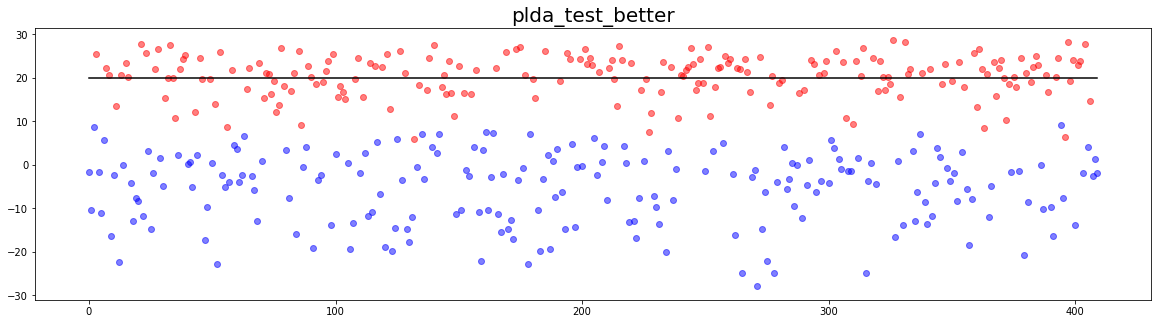

err=0.1780, eer=0.0000, fpr=0.0000, fnr=0.3561, thres=20.0000


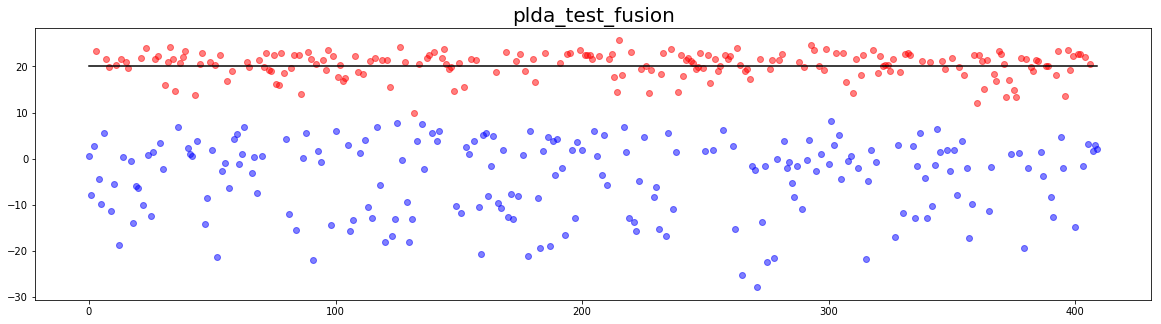

In [84]:
plot_score(plda_single_scores[10,:], test_trial[1], threshold=20, title="plda_test_worse")
plot_score(plda_single_scores[6,:], test_trial[1], threshold=20, title="plda_test_better")
plot_score(plda_single_scores.mean(0), test_trial[1], threshold=20, title="plda_test_fusion")